In [18]:
# Cell 1: 导入库与全局配置

import os
import glob
import numpy as np
import pandas as pd
from collections import defaultdict
import re
import io
import joblib

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
DATASET_PATH = 'MobiFall_Dataset'
TARGET_SAMPLING_RATE_HZ = 50.0  # Target sampling rate in Hz
TARGET_SAMPLING_PERIOD = f"{int(1000 / TARGET_SAMPLING_RATE_HZ)}ms"
SEQUENCE_LENGTH = int(TARGET_SAMPLING_RATE_HZ * 4) # 200 samples for 4 seconds at 50Hz
STEP = int(TARGET_SAMPLING_RATE_HZ * 1)          # 50 samples for 1 second step at 50Hz

SENSOR_CODES = ["acc", "gyro", "ori"]
EXPECTED_COLUMNS = {
    "acc": ["acc_x", "acc_y", "acc_z"],
    "gyro": ["gyro_x", "gyro_y", "gyro_z"],
    "ori": ["ori_azimuth", "ori_pitch", "ori_roll"]
}
ALL_FEATURE_COLUMNS = [
    "acc_x", "acc_y", "acc_z", "acc_smv",
    "gyro_x", "gyro_y", "gyro_z", "gyro_smv",
    "ori_azimuth", "ori_pitch", "ori_roll"
]

In [ ]:
# Cell 2: 数据加载与预处理函数

def load_and_resample_sensor_file(filepath, sensor_code):
    """加载单个传感器文件，转换时间戳并进行重采样。"""
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()

        # 初始化一个变量作为“标记未找到”的标志
        data_start_line_index = -1

        # 遍历文件中的每一行
        for i, line in enumerate(lines):
            # 检查当前行是否是"@DATA"标记
            if line.strip().upper() == "@DATA":
                # 如果是，则记录下一行的行号并跳出循环
                data_start_line_index = i + 1
                break

        # 检查标记是否被找到
        if data_start_line_index == -1 or data_start_line_index >= len(lines):
            return None

        # 将数据行拼接成单个字符串
        data_string = "".join(lines[data_start_line_index:])

        # 检查字符串是否为空
        if not data_string.strip():
            return None

        # 使用pandas处理数据
        df = pd.read_csv(io.StringIO(data_string), header=None, usecols=[0, 1, 2, 3])
        
        # 检查生成的数据表是否为空
        if df.empty:
            return None

        # 为数据列进行命名
        df.columns = ['timestamp_ns'] + EXPECTED_COLUMNS[sensor_code]

        # 将ns时间戳转换为标准的日期时间格式
        df['timestamp'] = pd.to_datetime(df['timestamp_ns'], unit='ns')

        # 将新的日期时间设置为索引，并删除旧的时间戳列
        df = df.set_index('timestamp').drop(columns=['timestamp_ns'])

        # 按时间索引进行排序
        df = df.sort_index()

        # 将采样时间不均匀的传感器数据，强制转换为频率统一（每20毫秒一个点）的规整数据流，并填补其中的所有空白
        df_resampled = df.resample(TARGET_SAMPLING_PERIOD).mean().interpolate(method='linear', limit_direction='both')

        # 检查当前处理的传感器是否为加速度计 ('acc')
        if sensor_code == 'acc':
            # 安全性检查 - 确认三轴数据都存在
            if all(col in df_resampled.columns for col in ['acc_x', 'acc_y', 'acc_z']):
                # 计算信号幅值向量 (SMV)
                df_resampled['acc_smv'] = np.sqrt(
                    df_resampled['acc_x']**2 + df_resampled['acc_y']**2 + df_resampled['acc_z']**2
                )

        # 如果不是加速度计，则检查是否为陀螺仪 ('gyro')
        elif sensor_code == 'gyro':
            # 对陀螺仪数据执行相同的操作
            if all(col in df_resampled.columns for col in ['gyro_x', 'gyro_y', 'gyro_z']):
                df_resampled['gyro_smv'] = np.sqrt(
                    df_resampled['gyro_x']**2 + df_resampled['gyro_y']**2 + df_resampled['gyro_z']**2
                )

        return df_resampled

    except (pd.errors.EmptyDataError, ValueError):
        return None
    except Exception as e:
        print(f"Error processing file {filepath}: {e}. Skipping.")
        return None

def load_data_from_structured_folders(dataset_root_path):
    """遍历数据集文件夹，处理、对齐并组合每个试验的传感器数据。"""
    print(f"Scanning for data in: {dataset_root_path}")
    if not os.path.isdir(dataset_root_path):
        print(f"ERROR: Dataset root path '{dataset_root_path}' not found.")
        return [], []

    # 存放每一次活动试验（trial）所对应的各个传感器文件的路径（数据文件的位置）
    trial_sensor_files_map = defaultdict(lambda: defaultdict(str))

    # 存放每一次活动试验的元数据（这些数据代表什么，即标签信息）
    trial_metadata_map = {}
    
    # 遍历数据集的每一个文件夹
    for dirpath, _, filenames in os.walk(dataset_root_path):
        # 解析文件夹路径，以确定活动类别和具体活动
        relative_path = os.path.relpath(dirpath, dataset_root_path)
        path_parts = relative_path.split(os.sep)
        # 确保只处理包含实际数据文件的特定层级文件夹
        if len(path_parts) != 3: continue

        # 遍历这些特定文件夹中的每一个文件
        for filename in filenames:
            # 确保只处理.txt文件
            if not filename.endswith(".txt"): continue
            
            # 解析文件名，通过下划线分割以获取各个部分
            fname_parts = filename.replace('.txt', '').split('_')
            # 过滤掉不符合预期格式的文件名
            if len(fname_parts) != 4: continue
            
            # 从文件名部分中提取所需信息
            _, sensor_code, _, trial_no_str = fname_parts
            # 将传感器代码转为小写以保持一致性
            sensor_code = sensor_code.lower()
            # 确保是已知的传感器类型 ('acc', 'gyro', 'ori')
            if sensor_code not in SENSOR_CODES: continue

            # 尝试从路径和文件名中提取并转换所有元数据
            try:
                # 从文件夹路径的第一部分提取受试者ID
                subject_match = re.fullmatch(r'sub(\d+)', path_parts[0], re.IGNORECASE)
                if not subject_match: continue
                subject_id = int(subject_match.group(1))
                
                # 从文件夹路径的第二和第三部分获取类别和活动代码
                category = path_parts[1].upper()
                activity_code = path_parts[2].upper()
                # 将试验编号从字符串转换为整数
                trial_no = int(trial_no_str)
                # 构建完整的文件路径
                filepath = os.path.join(dirpath, filename)
                
                # 创建一个唯一的键来标识这次试验 (受试者, 活动, 试验编号)
                trial_key = (subject_id, activity_code, trial_no)
                # 在映射表中存储该传感器文件的路径
                trial_sensor_files_map[trial_key][sensor_code] = filepath
                # 如果是第一次遇到这个试验，则记录其元数据（类别和活动代码）
                if trial_key not in trial_metadata_map:
                    trial_metadata_map[trial_key] = {"category": category, "activity_code": activity_code}
            except (AttributeError, ValueError):
                # 如果在提取或转换过程中出现任何错误，则跳过该文件
                continue

    # 初始化两个列表，用于存放最终处理好的数据和对应的标签
    processed_trials_data, labels = [], []
    print(f"\nProcessing and combining {len(trial_sensor_files_map)} unique trials...")
    
    # 遍历前面组织好的每一次活动试验（trial）
    for trial_key, sensor_files in trial_sensor_files_map.items():
        # 确保该次试验包含了 acc, gyro, ori 全部三种传感器文件，否则跳过
        if not all(s_code in sensor_files for s_code in SENSOR_CODES): continue

        # 使用字典推导式，为每种传感器加载并重采样数据
        resampled_dfs = {s_code: load_and_resample_sensor_file(sensor_files[s_code], s_code) for s_code in SENSOR_CODES}
        # 如果任何一个文件加载或处理失败（返回了None或空表），则跳过这次试验
        if any(df is None or df.empty for df in resampled_dfs.values()): continue

        try:
            # --- 时间对齐关键步骤 ---
            # 找到三个传感器数据中最晚的开始时间
            common_start = max(df.index.min() for df in resampled_dfs.values())
            # 找到三个传感器数据中最早的结束时间
            common_end = min(df.index.max() for df in resampled_dfs.values())
            # 如果没有重叠的时间窗口，则跳过
            if common_start >= common_end: continue

            # 将三个数据表都裁剪到共同的时间范围内
            aligned_dfs = [resampled_dfs[s_code][common_start:common_end].reset_index(drop=True) for s_code in SENSOR_CODES]
            # 确保对齐后的数据表长度一致且不为空，否则跳过
            if not all(len(df) > 0 and len(df) == len(aligned_dfs[0]) for df in aligned_dfs): continue
            
            # --- 数据合并 ---
            # 按列（axis=1）将三个对齐后的数据表拼接成一个宽表
            combined_df = pd.concat(aligned_dfs, axis=1)
            
            # 再次检查并确保列名正确
            if len(combined_df.columns) == len(ALL_FEATURE_COLUMNS):
                 combined_df.columns = ALL_FEATURE_COLUMNS
            else:
                 continue # 如果列数不匹配则跳过

            # 如果合并后的数据长度不足一个序列窗口（4秒），则跳过
            if len(combined_df) < SEQUENCE_LENGTH: continue
            
            # --- 数据和标签存储 ---
            # 将处理好的数据（转换为Numpy数组）存入列表
            processed_trials_data.append(combined_df.values)
            # 根据元数据判断该试验是"FALLS"还是"ADL"，并存入标签（1代表跌倒，0代表非跌倒）
            labels.append(1 if trial_metadata_map[trial_key]["category"] == "FALLS" else 0)
            
        except Exception:
            # 捕获任何在对齐和合并过程中可能出现的意外错误，并跳过该试验
            continue

    print(f"Successfully processed and combined sensor data for {len(processed_trials_data)} trials.")
    # 返回包含所有处理好的试验数据和标签的列表
    return processed_trials_data, labels

def create_sequences(data_list, label_list, seq_length, step):
    """使用滑动窗口从试验数据创建序列。"""
    # 初始化用于存放最终序列和对应标签的列表
    X, y = [], []
    # 遍历每一次活动试验的数据
    for i, trial_data in enumerate(data_list):
        trial_label = label_list[i]
        # 在单次试验数据上，按指定的步长（step）移动窗口
        for j in range(0, len(trial_data) - seq_length + 1, step):
            # 截取一个固定长度（seq_length）的片段作为序列
            X.append(trial_data[j:(j + seq_length)])
            # 为这个序列分配对应的标签
            y.append(trial_label)
            
    if not X: return np.array([]), np.array([])
    # 将列表转换为Numpy数组后返回
    return np.array(X), np.array(y)

In [20]:
# Cell 3: PyTorch Dataset 类

class FallDetectionDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [ ]:
# Cell 4: 数据准备与 DataLoader 创建

# 1. 加载和创建序列
trial_arrays, trial_labels = load_data_from_structured_folders(DATASET_PATH)
X_sequences, y_sequences = create_sequences(trial_arrays, trial_labels, SEQUENCE_LENGTH, STEP)
print(f"Created {X_sequences.shape[0]} sequences.")

# 2. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.25, random_state=42, stratify=y_sequences
)
print(f"Train set: {X_train.shape}; Test set: {X_test.shape}")


# 3. 数据标准化
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[2])
X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)
X_train = X_train_scaled_reshaped.reshape(X_train.shape)

X_test_reshaped = X_test.reshape(-1, X_test.shape[2])
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)
X_test = X_test_scaled_reshaped.reshape(X_test.shape)

# 保存 scaler
scaler_save_path = "scaler_50hz_torch.gz"
joblib.dump(scaler, scaler_save_path)
print(f"Data scaled and scaler saved to {scaler_save_path}")


# 4. 创建 Dataset 和 DataLoader
train_dataset = FallDetectionDataset(X_train, y_train)
test_dataset = FallDetectionDataset(X_test, y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Scanning for data in: MobiFall_Dataset

Processing and combining 627 unique trials...
Successfully processed and combined sensor data for 627 trials.
Created 9491 sequences.
Train set: (7118, 200, 11); Test set: (2373, 200, 11)
Data scaled and scaler saved to scaler_50hz_torch.gz


In [22]:
# Cell 5: PyTorch 模型定义

class FallDetectionModel(nn.Module):
    def __init__(self, n_features):
        super(FallDetectionModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=64, kernel_size=10)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.3)
        
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(0.4)
        
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=32, batch_first=True, bidirectional=True)
        self.dropout3 = nn.Dropout(0.4)
        
        self.fc1 = nn.Linear(32 * 2, 32) # Bidirectional a_b * 2
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # Conv1d expects (N, C, L)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        # Permute back for LSTM: (N, L, C)
        x = x.permute(0, 2, 1)
        x = self.dropout1(x)
        
        x, _ = self.lstm1(x)
        x = self.dropout2(x)
        
        x, _ = self.lstm2(x)
        x = self.dropout3(x)
        
        # We only need the last hidden state
        x = self.fc1(x[:, -1, :])
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 实例化模型并打印结构
n_features = X_train.shape[2]
model = FallDetectionModel(n_features)
print(model)

FallDetectionModel(
  (conv1): Conv1d(11, 64, kernel_size=(10,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm1): LSTM(64, 64, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (lstm2): LSTM(128, 32, batch_first=True, bidirectional=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [23]:
# Cell 6 模型循环训练
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 计算类别权重以处理不平衡数据
# pos_weight = count(negative) / count(positive)
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
pos_weight = torch.tensor([neg_count / pos_count], dtype=torch.float32).to(device)

# 损失函数和优化器
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.2)

# 早停参数
patience = 10
best_val_loss = float('inf')
patience_counter = 0

# 训练参数
epochs = 50

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # 验证
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for sequences, labels in test_loader: # 使用测试集作为验证集
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
            
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    scheduler.step(avg_val_loss)

    # 早停逻辑
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # 保存最佳模型
        torch.save(model.state_dict(), "fall_detection_model_50hz_torch.pth")
        print("Model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training finished.")

Epoch 1/50, Train Loss: 0.3605, Val Loss: 0.1374
Model saved.
Epoch 2/50, Train Loss: 0.1058, Val Loss: 0.1273
Model saved.
Epoch 3/50, Train Loss: 0.0994, Val Loss: 0.1085
Model saved.
Epoch 4/50, Train Loss: 0.0905, Val Loss: 0.1128
Epoch 5/50, Train Loss: 0.0781, Val Loss: 0.1257
Epoch 6/50, Train Loss: 0.0940, Val Loss: 0.1115
Epoch 7/50, Train Loss: 0.0731, Val Loss: 0.0900
Model saved.
Epoch 8/50, Train Loss: 0.0665, Val Loss: 0.0998
Epoch 9/50, Train Loss: 0.0662, Val Loss: 0.0971
Epoch 10/50, Train Loss: 0.0654, Val Loss: 0.0775
Model saved.
Epoch 11/50, Train Loss: 0.0488, Val Loss: 0.0859
Epoch 12/50, Train Loss: 0.0411, Val Loss: 0.0614
Model saved.
Epoch 13/50, Train Loss: 0.0440, Val Loss: 0.0618
Epoch 14/50, Train Loss: 0.0381, Val Loss: 0.0394
Model saved.
Epoch 15/50, Train Loss: 0.0316, Val Loss: 0.0476
Epoch 16/50, Train Loss: 0.0292, Val Loss: 0.0393
Model saved.
Epoch 17/50, Train Loss: 0.0243, Val Loss: 0.0431
Epoch 18/50, Train Loss: 0.0199, Val Loss: 0.0913
Epoch


Evaluating model on the test set...


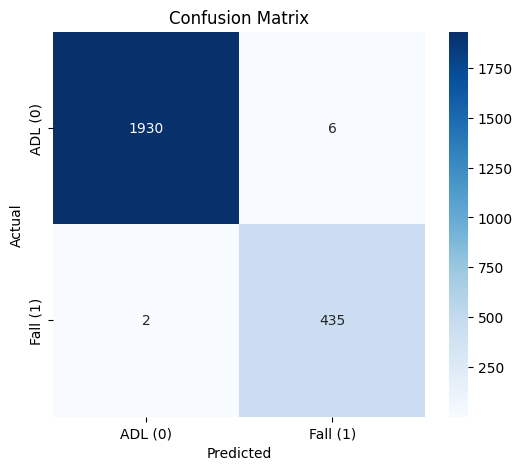


Classification Report:
               precision    recall  f1-score   support

     ADL (0)       1.00      1.00      1.00      1936
    Fall (1)       0.99      1.00      0.99       437

    accuracy                           1.00      2373
   macro avg       0.99      1.00      0.99      2373
weighted avg       1.00      1.00      1.00      2373



In [25]:
# Cell 7: 模型评估与结果可视化
# 加载最佳模型权重
model.load_state_dict(torch.load("fall_detection_model_50hz_torch.pth"))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device)
        outputs = model(sequences)
        
        # 将 logits 转换为概率，然后转换为预测类别 (0 或 1)
        preds = torch.sigmoid(outputs).squeeze().round().cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# 计算指标
print("\nEvaluating model on the test set...")
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=['ADL (0)', 'Fall (1)'])

# 可视化混淆矩阵
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ADL (0)', 'Fall (1)'],
            yticklabels=['ADL (0)', 'Fall (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n", report)